In [1]:
!pip install -qU torch_snippets

In [2]:
from torch_snippets import *
from PIL import Image

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
image_root = '/kaggle/input/open-images-bus-trucks/images/images'
df_raw = df = pd.read_csv('/kaggle/input/open-images-bus-trucks/df.csv')

In [4]:
df_raw.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.343750,0.908750,0.156162,0.650047,1,0,...,0,0,0.421875,0.343750,0.795000,0.908750,0.156162,0.512700,0.650047,0.457197
1,00006bdb1eb5cd74,xclick,Truck,1,0.276667,0.697500,0.141604,0.437343,1,0,...,0,0,0.299167,0.276667,0.697500,0.659167,0.141604,0.241855,0.352130,0.437343
2,00006bdb1eb5cd74,xclick,Truck,1,0.702500,0.999167,0.204261,0.409774,1,1,...,0,0,0.849167,0.702500,0.906667,0.999167,0.204261,0.398496,0.409774,0.295739
3,00010bf498b64bab,xclick,Bus,1,0.156250,0.371250,0.269188,0.705228,0,0,...,0,0,0.274375,0.371250,0.311875,0.156250,0.269188,0.493882,0.705228,0.521691
4,00013f14dd4e168f,xclick,Bus,1,0.287500,0.999375,0.194184,0.999062,0,1,...,0,0,0.920000,0.999375,0.648750,0.287500,0.194184,0.303940,0.999062,0.523452


In [5]:
label2target = {l:t+1 for t, l in enumerate(df_raw['LabelName'].unique())}
label2target['background'] = 0
target2label = {t:l for l, t in label2target.items()}
background_class = label2target['background']
num_classes = len(label2target)

In [6]:
def preprocess_image(img):
    img = torch.tensor(img).permute(2, 0, 1)
    return img.to(device).float()

In [7]:
import glob

In [8]:
class OpenDataset(torch.utils.data.Dataset):
    w, h = 224, 224
    def __init__(self, df, image_dir=image_root):
        self.image_dir = image_dir
        self.files = glob.glob(self.image_dir + '/*')
        self.df = df
        self.image_infos = df.ImageID.unique()

    def __getitem__(self, ix):
        image_id = self.image_infos[ix]
        img_path = find(image_id, self.files)
        img = Image.open(img_path).convert('RGB')
        img = np.array(img.resize((self.w, self.h), resample=Image.BILINEAR)) / 255.
        data = self.df[self.df['ImageID']==image_id]
        labels = data['LabelName'].values.tolist()
        data = data[['XMin', 'YMin', 'XMax', 'YMax']].values

        data[:, [0, 2]] *= self.w
        data[:, [1, 3]] *= self.h
        boxes = data.astype(np.uint32).tolist()

        target = {}
        target['boxes'] = torch.Tensor(boxes).float()
        target['labels'] = torch.Tensor([label2target[i] for i in labels]).long()
        img = preprocess_image(img)
        return img, target

    def collate_fn(self, batch):
        return tuple(zip(*batch))

    def __len__(self):
        return len(self.image_infos)

In [9]:
from sklearn.model_selection import train_test_split

train_ids, valid_ids = train_test_split(df.ImageID.unique(), test_size=0.1)
train_df, valid_df = df[df['ImageID'].isin(train_ids)], df[df['ImageID'].isin(valid_ids)]

train_ds = OpenDataset(train_df)
valid_ds = OpenDataset(valid_df)

train_loader = DataLoader(train_ds, batch_size=4, collate_fn=train_ds.collate_fn, drop_last=True)
valid_loader = DataLoader(valid_ds, batch_size=4, collate_fn=valid_ds.collate_fn, drop_last=True)

In [10]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def get_model():
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [11]:
model = get_model()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 73.0MB/s] 


In [12]:
!pip install -q torch-summary
from torchsummary import summary

In [13]:
summary(model)

Layer (type:depth-idx)                             Param #
├─GeneralizedRCNNTransform: 1-1                    --
├─BackboneWithFPN: 1-2                             --
|    └─IntermediateLayerGetter: 2-1                --
|    |    └─Conv2d: 3-1                            (9,408)
|    |    └─FrozenBatchNorm2d: 3-2                 --
|    |    └─ReLU: 3-3                              --
|    |    └─MaxPool2d: 3-4                         --
|    |    └─Sequential: 3-5                        (212,992)
|    |    └─Sequential: 3-6                        1,212,416
|    |    └─Sequential: 3-7                        7,077,888
|    |    └─Sequential: 3-8                        14,942,208
|    └─FeaturePyramidNetwork: 2-2                  --
|    |    └─ModuleList: 3-9                        984,064
|    |    └─ModuleList: 3-10                       2,360,320
|    |    └─LastLevelMaxPool: 3-11                 --
├─RegionProposalNetwork: 1-3                       --
|    └─AnchorGenerator: 2-3    

Layer (type:depth-idx)                             Param #
├─GeneralizedRCNNTransform: 1-1                    --
├─BackboneWithFPN: 1-2                             --
|    └─IntermediateLayerGetter: 2-1                --
|    |    └─Conv2d: 3-1                            (9,408)
|    |    └─FrozenBatchNorm2d: 3-2                 --
|    |    └─ReLU: 3-3                              --
|    |    └─MaxPool2d: 3-4                         --
|    |    └─Sequential: 3-5                        (212,992)
|    |    └─Sequential: 3-6                        1,212,416
|    |    └─Sequential: 3-7                        7,077,888
|    |    └─Sequential: 3-8                        14,942,208
|    └─FeaturePyramidNetwork: 2-2                  --
|    |    └─ModuleList: 3-9                        984,064
|    |    └─ModuleList: 3-10                       2,360,320
|    |    └─LastLevelMaxPool: 3-11                 --
├─RegionProposalNetwork: 1-3                       --
|    └─AnchorGenerator: 2-3    

In [14]:
def train_batch(inputs, model, optimizer):
    model.train()
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optimizer.step()
    return loss, losses

In [15]:
@torch.no_grad()
def validate_batch(inputs, model):
    model.train()
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    return loss, losses

In [16]:
model = get_model().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

EPOCH: 1.000  trn_loc_loss: 0.076  trn_objectness_loss: 0.017  val_loc_loss: 0.071  trn_loss: 0.184  trn_regr_loss: 0.083  val_objectness_loss: 0.015  val_rpn_box_reg_loss: 0.008  val_loss: 0.174  val_regr_loss: 0.079  trn_rpn_box_reg_loss: 0.009  (1774.44s - 7097.75s remaining)
EPOCH: 2.000  trn_loc_loss: 0.065  trn_objectness_loss: 0.010  val_loc_loss: 0.074  trn_loss: 0.157  trn_regr_loss: 0.074  val_objectness_loss: 0.016  val_rpn_box_reg_loss: 0.008  val_loss: 0.181  val_regr_loss: 0.084  trn_rpn_box_reg_loss: 0.007  (3405.77s - 5108.65s remaining)
EPOCH: 3.000  trn_loc_loss: 0.062  trn_objectness_loss: 0.009  val_loc_loss: 0.073  trn_loss: 0.151  trn_regr_loss: 0.072  val_objectness_loss: 0.016  val_rpn_box_reg_loss: 0.008  val_loss: 0.180  val_regr_loss: 0.083  trn_rpn_box_reg_loss: 0.007  (5036.37s - 3357.58s remaining)
EPOCH: 4.000  trn_loc_loss: 0.057  trn_objectness_loss: 0.008  val_loc_loss: 0.082  trn_loss: 0.141  trn_regr_loss: 0.070  val_objectness_loss: 0.017  val_rpn_b

  0%|          | 0/106 [00:00<?, ?it/s]


AttributeError: 'Report' object has no attribute 'train_loss'

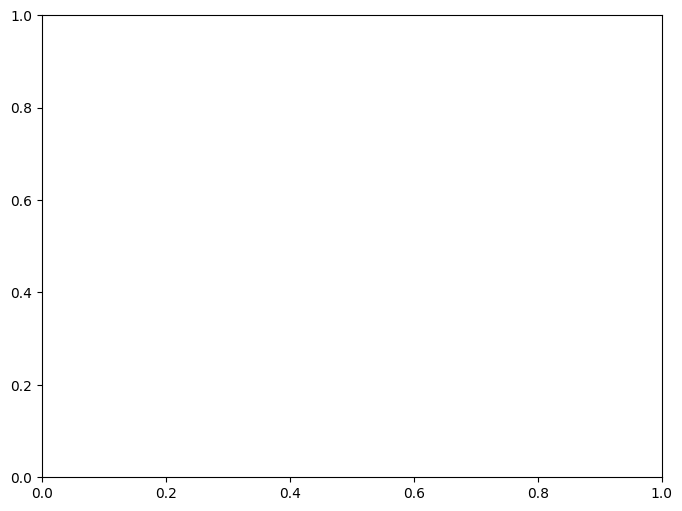

In [17]:
n_epochs = 5
log = Report(n_epochs)

for epoch in range(n_epochs):
    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, losses = train_batch(inputs, model, optimizer)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = [losses[k] for k in ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg']]
        pos = (epoch + (ix + 1) / _n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss.item(), trn_regr_loss=regr_loss.item(), trn_objectness_loss=loss_objectness.item(), trn_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='/r')

    _n = len(valid_loader)
    for ix, inputs in enumerate(valid_loader):
        loss, losses = validate_batch(inputs, model)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = [losses[k] for k in ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg']]
        pos = (epoch + (ix +  1) / _n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss.item(), val_regr_loss=regr_loss.item(), val_objectness_loss=loss_objectness.item(), val_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='/r')

    if (epoch + 1) % (n_epochs // 5) == 0:
        log.report_avgs(epoch + 1)

log.plot_epochs(['train_loss', 'valid_loss'])

100%|██████████| 106/106 [00:00<00:00, 149.97it/s]


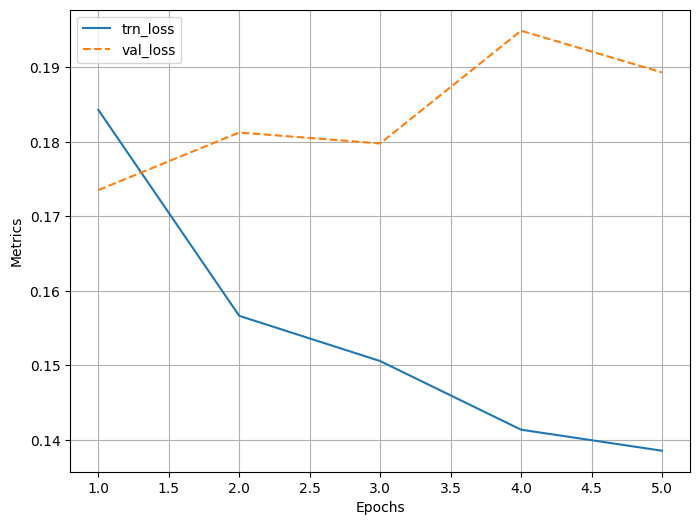

In [19]:
log.plot_epochs(['trn_loss', 'val_loss'])

In [20]:
from torchvision.ops import nms

def decode_output(output):
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels = np.array([target2label[i] for i in output['labels'].cpu().detach().numpy()])
    confs = output['scores'].cpu().detach().numpy()
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    bbs, confs, labels = [tensor[ixs] for tensor in [bbs, confs, labels]]
    
    if len(ixs) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
    
    return bbs.tolist(), confs.tolist(), labels.tolist()

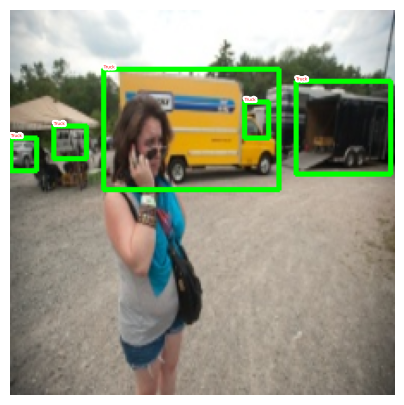

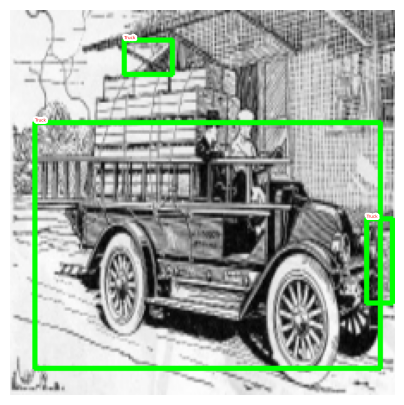

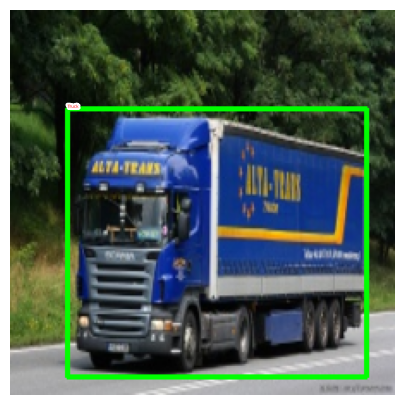

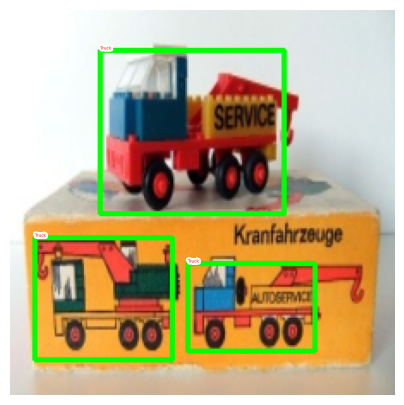

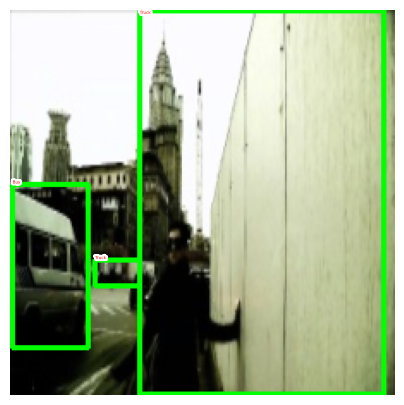

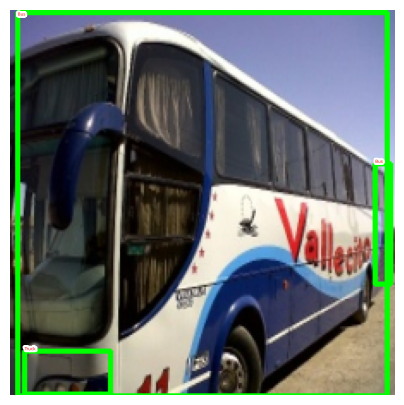

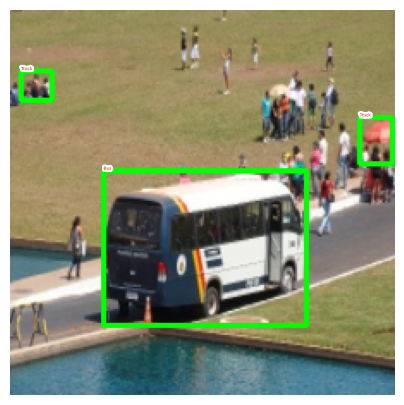

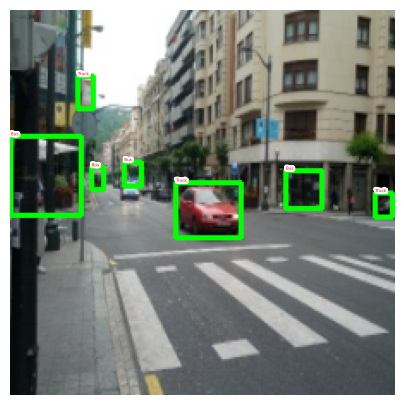

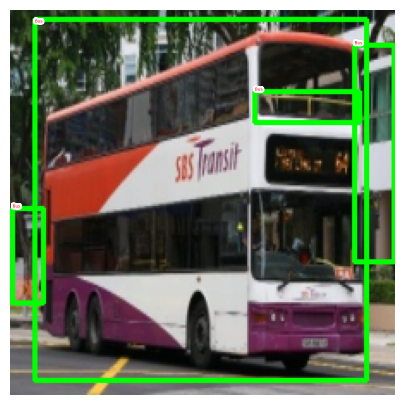

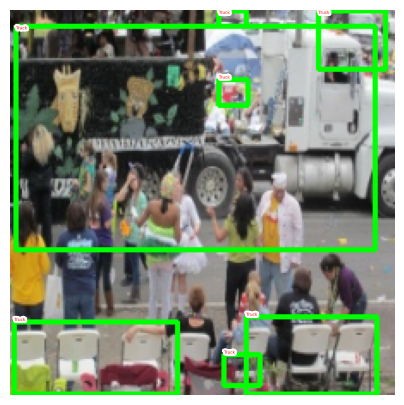

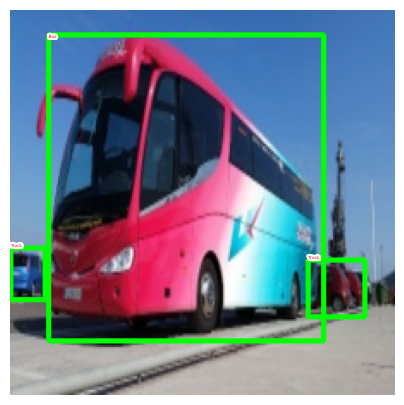

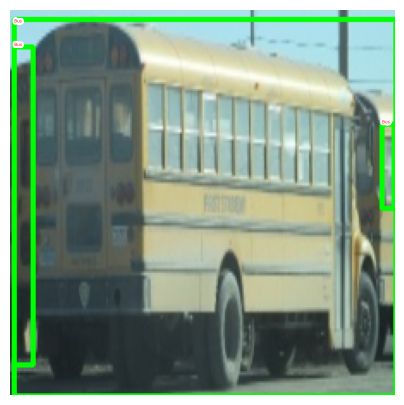

In [23]:
model.eval()
for ix, (images, targets) in enumerate(valid_loader):
    if ix == 3: break
    images = [im for im in images]
    outputs = model(images)
    for ix, output in enumerate(outputs):
        bbs, confs, labels = decode_output(output)
        info = [f'{l}@{c:.2f}' for l, c in zip(labels, confs)]
        show(images[ix].cpu().permute(1, 2, 0), bbs=bbs, texts=labels, sz=5)